<a href="https://colab.research.google.com/github/ScientistLim/ProjectAW/blob/feature%2Fdata-preprocessing/%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%A0%84%EC%B2%98%EB%A6%AC_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%ED%95%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving data.csv to data.csv
X_train 차원:  (7211, 30, 2)
X_test 차원:  (1803, 30, 2)


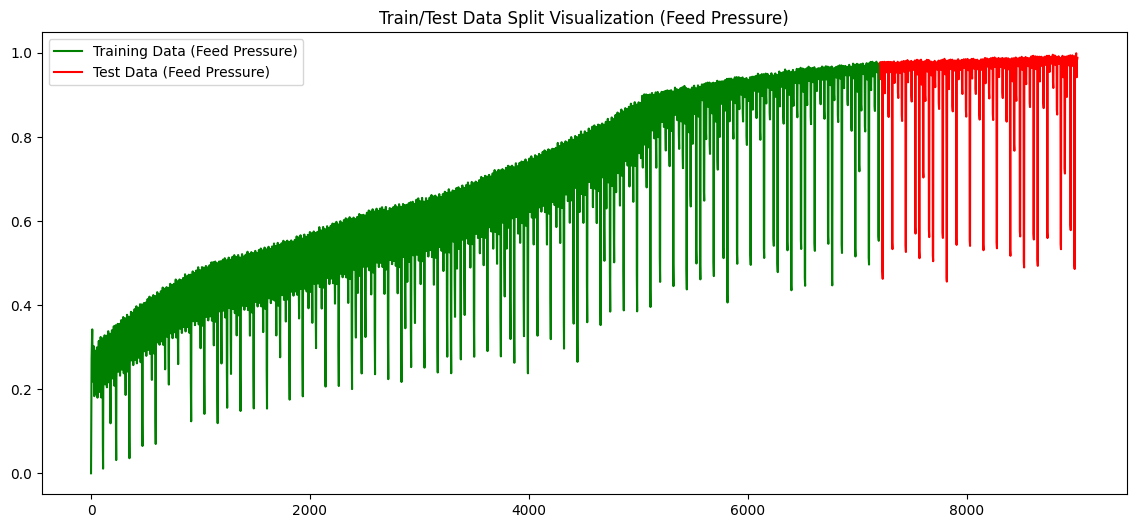

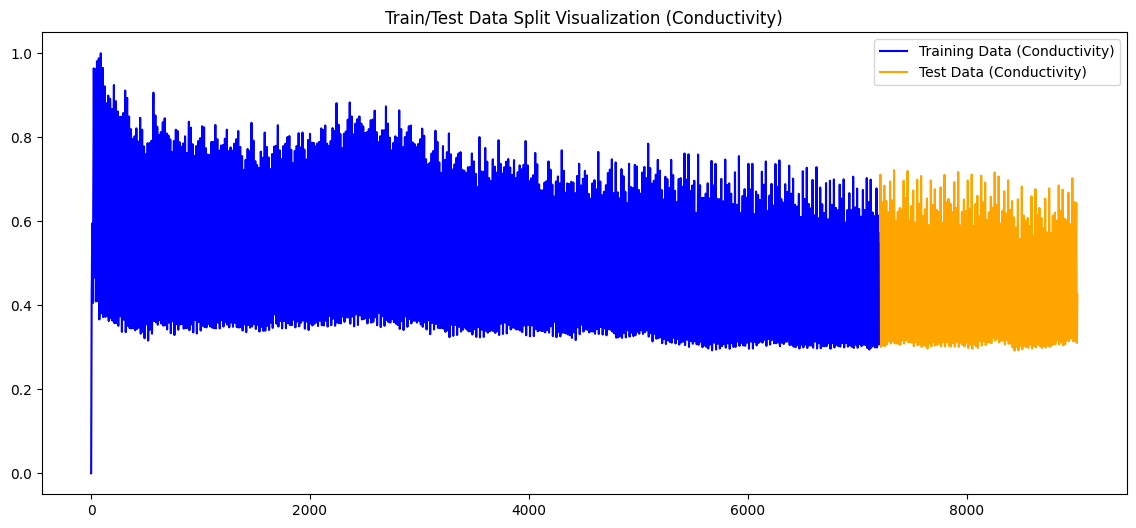

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from google.colab import files
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split

# 시각화를 위한 설정 (Google Colab에서 반드시 필요)
%matplotlib inline

# 1. CSV 파일 업로드
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

# 2. 압력과 처리수 전기전도도 변수 선택
df = df[['RO 처리수 전기전도도(uS/cm)', 'RO유입 압력(bar)']]
df.columns = ['conductivity', 'feed_pressure']  # 열 이름을 사용하기 쉽게 변경

# 원본 데이터 저장
original_feed_pressure = df['feed_pressure'].values
original_conductivity = df['conductivity'].values

# 3. 이상치 탐지 및 제거 (IQR 기법)
def remove_outliers_iqr(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]

df_cleaned = remove_outliers_iqr(df)


# 4. 데이터 스무딩 및 패딩 (이동 평균 적용)
def smooth_and_interpolate(data, window_size):
    def moving_average(data, window_size):
        return np.convolve(data, np.ones(window_size) / window_size, mode='same')

    def add_padding(data, padding_size):
        start_padding = np.full(padding_size, data[0])
        end_padding = np.full(padding_size, data[-1])
        return np.concatenate([start_padding, data, end_padding])

    # 패딩 적용
    padded_data = add_padding(data.flatten(), window_size)

    # 이동 평균 적용
    rolled_data = moving_average(padded_data, window_size)

    # 패딩 제거
    rolled_data_trimmed = rolled_data[window_size:-window_size]

    return rolled_data_trimmed

window_size = 5

# 데이터 스무딩 및 패딩 처리
df_smoothed = df_cleaned.copy()
df_smoothed['smoothed_feed_pressure'] = smooth_and_interpolate(df_smoothed['feed_pressure'].values, window_size)
df_smoothed['smoothed_conductivity'] = smooth_and_interpolate(df_smoothed['conductivity'].values, window_size)


# 5. Min-Max 스케일링
scaler_feed_pressure = MinMaxScaler()
scaler_conductivity = MinMaxScaler()

df_smoothed['scaled_feed_pressure'] = scaler_feed_pressure.fit_transform(df_smoothed[['smoothed_feed_pressure']].values.reshape(-1, 1))
df_smoothed['scaled_conductivity'] = scaler_conductivity.fit_transform(df_smoothed[['smoothed_conductivity']].values.reshape(-1, 1))

# 6. 시퀀스 생성 함수 정의
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i + sequence_length]
        label = data[i + sequence_length]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# 시퀀스 길이 설정
sequence_length = 30

# 두 변수 동시 시퀀스 생성 (Feed Pressure와 Conductivity)
scaled_values = df_smoothed[['scaled_feed_pressure', 'scaled_conductivity']].values
X_sequences, y_sequences = create_sequences(scaled_values, sequence_length)

# 7. 훈련 및 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, shuffle=False)

# 반환된 배열 차원 확인
print("X_train 차원: ", X_train.shape)
print("X_test 차원: ", X_test.shape)

# 8. 시각화를 통해 훈련/테스트 데이터 비교
# Feed Pressure 데이터 시각화
plt.figure(figsize=(14, 6))
plt.plot(np.arange(len(X_train)), X_train[:, 0, 0], label='Training Data (Feed Pressure)', color='green')
plt.plot(np.arange(len(X_train), len(X_train) + len(X_test)), X_test[:, 0, 0], label='Test Data (Feed Pressure)', color='red')
plt.title('Train/Test Data Split Visualization (Feed Pressure)')
plt.legend()
plt.show()

# Conductivity 데이터 시각화
plt.figure(figsize=(14, 6))
plt.plot(np.arange(len(X_train)), X_train[:, 0, 1], label='Training Data (Conductivity)', color='blue')
plt.plot(np.arange(len(X_train), len(X_train) + len(X_test)), X_test[:, 0, 1], label='Test Data (Conductivity)', color='orange')
plt.title('Train/Test Data Split Visualization (Conductivity)')
plt.legend()
plt.show()

# 9. 스케일 역변환
#inverse_feed_pressure = scaler_feed_pressure.inverse_transform(df_smoothed['scaled_feed_pressure'].values.reshape(-1, 1))
#inverse_conductivity = scaler_conductivity.inverse_transform(df_smoothed['scaled_conductivity'].values.reshape(-1, 1))


# 10. CSV 파일 저장 및 다운로드
# 이상치 제거 - 스케일링된 데이터 저장

#scaled_df = pd.DataFrame({
#    'Scaled Feed Pressure': df_smoothed['scaled_feed_pressure'],
#    'Scaled Conductivity': df_smoothed['scaled_conductivity']
#})
#scaled_df.to_csv('scaled_data.csv', index=False)
#files.download('scaled_data.csv')

# 이상치 제거 - 스케일 역변환된 데이터 저장
#inverse_transformed_df = pd.DataFrame({
#    'Inverse Transformed Feed Pressure': inverse_feed_pressure.flatten(),
#    'Inverse Transformed Conductivity': inverse_conductivity.flatten()
#})
#inverse_transformed_df.to_csv('inverse_transformed_data.csv', index=False)
#files.download('inverse_transformed_data.csv')
